In [ ]:
# run this command when these libraries/packages are not installed
# pip install nibabel matplotlib nilearn dipy pandas numpy matplotlib

In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
from nibabel.processing import resample_from_to
from nilearn import plotting

from dipy.reconst.dti import TensorModel, fractional_anisotropy, mean_diffusivity, radial_diffusivity, axial_diffusivity
from dipy.io.image import load_nifti_data
from dipy.core.gradients import gradient_table

In [64]:
main_dir = "/media/ist/Drive2/MANSOOR/Neuroimaging-Project/DTI-Analysis"
data_dir = f"{main_dir}/Data/test"
results_dir = f"{main_dir}/results"

In [73]:
# set the DTI and atlas file paths -- assuming that the DTI file is preprocessed
data_files = os.path.join(data_dir, 'sherbrooke_3shell')
bvals_file = os.path.join(data_files, 'HARDI193.bval') 
bvecs_file = os.path.join(data_files, 'HARDI193.bvec')
img_file = os.path.join(data_files, 'HARDI193.nii.gz')  
atlas_file = os.path.join(data_dir, 'AAL.nii.gz')  

# Load data
img = nib.load(img_file)
atlas = nib.load(atlas_file)
bvals = np.loadtxt(bvals_file)
bvecs = np.loadtxt(bvecs_file)
print(img.shape,  atlas.shape, bvals.shape, bvecs.shape)

# gradient_table needs to be constructed when the gtab_file is not directly usable
gtab = gradient_table(bvals, bvecs)

(128, 128, 60, 193) (91, 109, 91) (193,) (3, 193)


Visualize the DTI image and atlas 

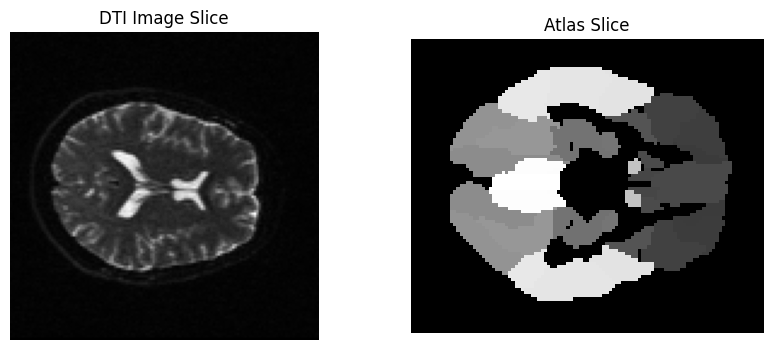

In [71]:
# Get the data from the images
img_data = img.get_fdata()
atlas_data = atlas.get_fdata()

# Choose a slice index
slice_index = 30  # You might need to adjust this based on your data

# Display the DTI image slice
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_data[:, :, slice_index, 0], cmap='gray')  # Showing the first b0 image
plt.title('DTI Image Slice')
plt.axis('off')

# Display the corresponding atlas slice
plt.subplot(1, 2, 2)
plt.imshow(atlas_data[:, :, slice_index], cmap='gray')  # Adjust if your atlas has a different orientation
plt.title('Atlas Slice')
plt.axis('off')

plt.show()

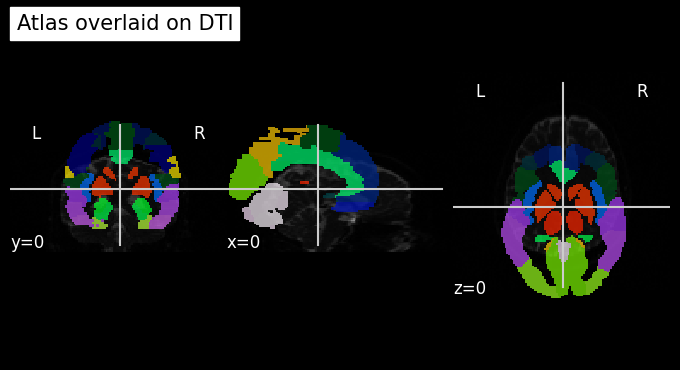

In [72]:
# display the DTI image with the atlas overlaid
plotting.plot_roi(atlas, bg_img=img.slicer[:,:,:,0], display_mode='ortho', cut_coords=(0, 0, 0), title="Atlas overlaid on DTI")
plotting.show()

In [51]:
# resample the atlas to the dti image when they have different sizes
atlas_resampled = resample_from_to(atlas, img.slicer[:,:,:,0], order=0)  # Using nearest-neighbor interpolation

# Check new shapes
print("Resampled atlas shape:", atlas_resampled.shape)
print("DTI image shape:", img.shape)


Resampled atlas shape: (128, 128, 60)
DTI image shape: (128, 128, 60, 193)


In [58]:
# fit the tensor model and compute the diffusion features
tensor_model = TensorModel(gtab)
tensor_fit = tensor_model.fit(img.get_fdata()) # because img already loaded as nibabel nii obj, need to convert to array

FA = fractional_anisotropy(tensor_fit.evals)
MD = mean_diffusivity(tensor_fit.evals)
RD = radial_diffusivity(tensor_fit.evals)
AD = axial_diffusivity(tensor_fit.evals)

print(FA.shape, MD.shape, RD.shape, AD.shape)

(128, 128, 60) (128, 128, 60) (128, 128, 60) (128, 128, 60)


In [66]:
labels = atlas_resampled.get_fdata()  # Assuming atlas data is already loaded correctly
unique_labels = np.unique(labels)[1:]  # Exclude 0, assuming it's background

# Prepare DataFrame to hold features
df = pd.DataFrame(columns=['ROI', 'FA_mean', 'MD_mean', 'RD_mean', 'AD_mean'])

# Loop through each label and calculate mean DTI metrics
for roi in unique_labels:
    mask = labels == roi
    fa_mean = np.mean(FA[mask])
    md_mean = np.mean(MD[mask])
    rd_mean = np.mean(RD[mask])
    ad_mean = np.mean(AD[mask])
    
    # Create a DataFrame for the current ROI's metrics
    roi_df = pd.DataFrame({'ROI': [roi], 'FA_mean': [fa_mean], 'MD_mean': [md_mean], 'RD_mean': [rd_mean], 'AD_mean': [ad_mean]})
    
    # Concatenate the current DataFrame with the new row
    df = pd.concat([df, roi_df], ignore_index=True)

print(f"Size of the extracted features for this DTI image: {df.shape}")
print(df.head())
df.to_csv(f'{results_dir}/dti_metrics_by_roi.csv', index=False)


/tmp/ipykernel_61997/2877200039.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, roi_df], ignore_index=True)


Size of the extracted features for this DTI image: (112, 5)
      ROI   FA_mean   MD_mean   RD_mean   AD_mean
0  2001.0  0.598624  0.000225  0.000180  0.000314
1  2002.0  0.675811  0.000125  0.000086  0.000203
2  2101.0  0.449010  0.000410  0.000348  0.000532
3  2102.0  0.460864  0.000415  0.000348  0.000550
4  2111.0  0.397600  0.000492  0.000380  0.000716
